# First Pass: EDA & Naive Model

**Goal:** predict individual performance on the metrics outlined here: https://www.draftkings.com/help/rules/nba

*Initial thoughts*
    
    - Determine shape if polynomial specifications are needed
    - Likely heteroskedastic; consider RSEs or panel effects by position
    - Look at cross validation of forcasting dkp (total DK points) vs individual level points

*Analysis steps*

    - Pairwise exploration of variables
    - Naive model (just use OLS with RSE)
    - Engineer features to explore strength of oponent, player team streaks, etc

In [76]:
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt

In [77]:
df_16 = pd.read_pickle('C:\\Users\\dmoxley\\Documents\\GitHub\dk_nba\\season_16_metric20201224.pkl')

In [78]:
df_16.dtypes

date                     object
gmID                     object
playerID                 object
First_Last               object
First                    object
Last                     object
team                     object
opp                      object
location                  int64
total                   float64
spread                  float64
prior_dkp               float64
dkp_diff                float64
three_day_avg           float64
three_day_avg_diff      float64
team_points             float64
opp_points              float64
dkp                     float64
dk_sal                  float64
dk_sal_change           float64
fd sal                  float64
rest_day_bucket           int64
start_flag               object
actv_flag                object
pos                      object
min_played              float64
fgm                       int64
fga                       int64
pt                        int64
rb                        int64
as                        int64
st      

In [79]:
df_16.head(2)

,date,gmID,playerID,First_Last,First,Last,team,opp,location,total,...,oppOR,oppDR,oppFGM,usage,prior_game_usage,gm_score,prior_game_score,possessions,ppp,oppdfeff
0,20170412,20170412-min-hou,3816,Louis Williams,Louis,Williams,hou,min,0,227.0,...,10.0,39.0,48.0,24.26,0.00,3.0,0.0,100.195933,112.650283,112.566889
1,20170412,20170412-min-hou,4224,James Harden,James,Harden,hou,min,0,227.0,...,10.0,39.0,48.0,24.07,33.19,31.6,7.2,100.195933,112.650283,112.566889


In [80]:
df_16.describe()

,location,total,spread,prior_dkp,dkp_diff,three_day_avg,three_day_avg_diff,team_points,opp_points,dkp,...,oppOR,oppDR,oppFGM,usage,prior_game_usage,gm_score,prior_game_score,possessions,ppp,oppdfeff
count,35996.000000,35996.000000,35996.000000,35996.000000,35996.000000,35994.000000,35982.000000,35996.000000,35996.000000,35996.000000,...,35996.000000,35996.000000,35996.000000,35996.000000,35996.000000,35996.000000,35996.000000,35996.000000,35996.000000,35996.000000
mean,0.500306,212.181645,0.011515,16.865956,0.026545,14.734619,-0.002838,105.548561,105.557173,14.722636,...,10.141432,33.351928,39.008334,13.787483,13.787970,5.527953,5.531768,96.339499,105.821410,108.313333
std,0.500007,51.255464,6.837311,14.031653,10.033055,13.502602,4.166288,12.165692,12.173012,15.151950,...,3.744674,5.289275,4.993402,18.105374,18.094515,7.061802,7.070360,5.701736,4.290884,3.497243
min,0.000000,180.000000,-22.000000,-1.500000,-61.500000,-0.500000,-27.750000,64.000000,64.000000,-1.500000,...,1.000000,18.000000,18.000000,0.000000,0.000000,-7.400000,-7.400000,80.026383,82.262461,83.955117
25%,0.000000,204.000000,-5.000000,5.500000,-4.000000,2.080000,-1.750000,97.000000,97.000000,0.000000,...,7.000000,30.000000,35.000000,0.000000,0.000000,0.000000,0.000000,92.454748,103.138466,106.512517
50%,1.000000,211.000000,0.000000,14.000000,0.000000,12.750000,0.000000,106.000000,106.000000,11.500000,...,10.000000,33.000000,39.000000,14.470000,14.470000,3.000000,3.000000,95.823748,105.475243,108.636276
75%,1.000000,217.500000,5.000000,25.000000,3.750000,22.920000,1.830000,114.000000,114.000000,24.250000,...,13.000000,37.000000,42.000000,21.860000,21.850000,9.300000,9.300000,99.840976,108.755039,110.499658
max,1.000000,1955.500000,22.000000,103.500000,69.250000,83.750000,32.170000,149.000000,149.000000,103.500000,...,26.000000,51.000000,57.000000,2266.090000,2266.090000,54.500000,54.500000,129.758622,127.299282,131.261507


### Data Wrangling

Rather than do any variable profiling, I'm just going to look for outliers and dive into engineering some features I think might be useful

*date* -- set to datetime

In [81]:
df_16['date'] = pd.to_datetime(df_16['date'].str[:4]+'-'+df_16['date'].str[4:6]+'-'+df_16['date'].str[6:])


,min,1st Q,mean,median,3rd Q,max
spread,1.0,3.0,5.909,5.0,8.0,22.0


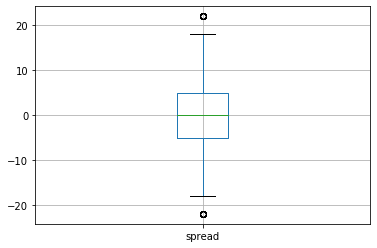

In [82]:
df = df_16
variable = 'spread'
summary = pd.DataFrame({'min': [round(df.loc[df[variable]>0,variable].min(),3)]
                                , '1st Q': [np.percentile(df.loc[df[variable]>0,variable],25)]
                                , 'mean': [round(df.loc[df[variable]>0,variable].mean(),3)]
                                , 'median': [round(df.loc[df[variable]>0,variable].median(),3)]
                                , '3rd Q': [np.percentile(df.loc[df[variable]>0,variable], 75)] 
                                , 'max': [round(df.loc[df[variable]>0,variable].max(),3)]}
                              , index=[variable])
df.boxplot(column=[variable])
summary

,min,1st Q,mean,median,3rd Q,max
spread,1.0,3.0,5.909,5.0,8.0,22.0


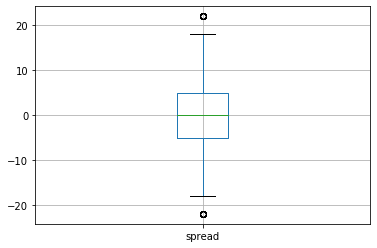

In [83]:
df = df_16
variable = 'spread'
summary = pd.DataFrame({'min': [round(df.loc[df[variable]>0,variable].min(),3)]
                                , '1st Q': [np.percentile(df.loc[df[variable]>0,variable],25)]
                                , 'mean': [round(df.loc[df[variable]>0,variable].mean(),3)]
                                , 'median': [round(df.loc[df[variable]>0,variable].median(),3)]
                                , '3rd Q': [np.percentile(df.loc[df[variable]>0,variable], 75)] 
                                , 'max': [round(df.loc[df[variable]>0,variable].max(),3)]}
                              , index=[variable])
df.boxplot(column=[variable])
summary

,min,1st Q,mean,median,3rd Q,max
total,180.0,204.0,212.182,211.0,217.5,1955.5


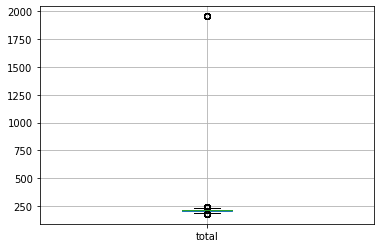

In [84]:
df = df_16
variable = 'total'
summary = pd.DataFrame({'min': [round(df.loc[df[variable]>0,variable].min(),3)]
                                , '1st Q': [np.percentile(df.loc[df[variable]>0,variable],25)]
                                , 'mean': [round(df.loc[df[variable]>0,variable].mean(),3)]
                                , 'median': [round(df.loc[df[variable]>0,variable].median(),3)]
                                , '3rd Q': [np.percentile(df.loc[df[variable]>0,variable], 75)] 
                                , 'max': [round(df.loc[df[variable]>0,variable].max(),3)]}
                              , index=[variable])
df.boxplot(column=[variable])
summary

In [85]:
#df_16.loc[df_16['total']>241,'total'].unique()
df_16['total'] = df_16['total'].replace(1955.5,195.55)

### Opposition Strength

Logic suggests performance is a function of team and player ability, the "Big Mo", the strength of competition.

Probably going to need to engineer some opposition variables to capture opponent strenght, but let's just confirm opposition matters.

Going to start with pairwise comparisons, might look at it as a panel model. I suspect SEs will cluster around individual player.

In [86]:
df_16['time_adj_total'] = df_16['total']/df_16['min_played']

In [87]:
# oppo variables &
oppo_vars = ['dkp','time_adj_total','opp_points','oppfga','oppfta','oppto','oppOR','oppDR','oppFGM','oppdfeff']
corr = df_16[oppo_vars].corr()
print('Opposition in current game has no impact on total points. Not sure that would ever make sense.')
corr.style.background_gradient(cmap='coolwarm').set_precision(2)


Opposition in current game has no impact on total points. Not sure that would ever make sense.


,dkp,time_adj_total,opp_points,oppfga,oppfta,oppto,oppOR,oppDR,oppFGM,oppdfeff
dkp,1.00,-0.11,0.01,0.03,0.01,0.02,0.00,-0.02,0.00,0.02
time_adj_total,-0.11,1.00,0.00,0.00,0.01,0.00,-0.00,0.00,0.00,0.00
opp_points,0.01,0.00,1.00,0.27,0.31,-0.11,-0.00,0.12,0.83,0.06
oppfga,0.03,0.00,0.27,1.00,-0.20,-0.25,0.52,0.15,0.44,0.06
oppfta,0.01,0.01,0.31,-0.20,1.00,0.04,0.07,0.04,-0.16,-0.02
oppto,0.02,0.00,-0.11,-0.25,0.04,1.00,0.07,0.12,-0.15,0.06
oppOR,0.00,-0.00,-0.00,0.52,0.07,0.07,1.00,-0.03,0.03,0.02
oppDR,-0.02,0.00,0.12,0.15,0.04,0.12,-0.03,1.00,0.10,-0.03
oppFGM,0.00,0.00,0.83,0.44,-0.16,-0.15,0.03,0.10,1.00,0.06
oppdfeff,0.02,0.00,0.06,0.06,-0.02,0.06,0.02,-0.03,0.06,1.00


In [88]:
# oppo variables & individual points breakout
oppo_vars = ['dkp','fgm','fga','pt','rb','as','st','bl','to','opp_points','oppfga','oppfta','oppto','oppOR','oppDR','oppFGM','oppdfeff']
corr = df_16[oppo_vars].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)
print('""You miss 100% of the shots you don''t take."-Wayne Gretsky" - Michael Scott')
corr.style.background_gradient(cmap='coolwarm').set_precision(2)


""You miss 100% of the shots you dont take."-Wayne Gretsky" - Michael Scott


,dkp,fgm,fga,pt,rb,as,st,bl,to,opp_points,oppfga,oppfta,oppto,oppOR,oppDR,oppFGM,oppdfeff
dkp,1.00,0.91,0.90,0.93,0.77,0.69,0.55,0.43,0.59,0.01,0.03,0.01,0.02,0.00,-0.02,0.00,0.02
fgm,0.91,1.00,0.92,0.97,0.60,0.53,0.41,0.30,0.53,0.03,0.02,0.01,0.00,0.00,-0.04,0.02,0.02
fga,0.90,0.92,1.00,0.92,0.61,0.59,0.45,0.29,0.57,0.02,0.02,0.01,0.01,-0.00,0.03,0.02,0.01
pt,0.93,0.97,0.92,1.00,0.59,0.55,0.42,0.29,0.56,0.03,0.03,0.02,0.00,0.00,-0.04,0.02,0.02
rb,0.77,0.60,0.61,0.59,1.00,0.36,0.33,0.44,0.45,-0.04,0.04,-0.00,-0.02,-0.01,0.01,-0.03,0.01
as,0.69,0.53,0.59,0.55,0.36,1.00,0.39,0.13,0.52,0.02,0.02,0.00,0.01,0.00,-0.03,0.02,0.01
st,0.55,0.41,0.45,0.42,0.33,0.39,1.00,0.17,0.35,-0.02,-0.03,0.00,0.17,0.01,0.01,-0.02,0.01
bl,0.43,0.30,0.29,0.29,0.44,0.13,0.17,1.00,0.21,-0.03,0.06,0.00,0.01,0.05,-0.00,-0.03,0.01
to,0.59,0.53,0.57,0.56,0.45,0.52,0.35,0.21,1.00,0.01,0.03,0.01,0.03,0.01,-0.05,0.01,-0.00
opp_points,0.01,0.03,0.02,0.03,-0.04,0.02,-0.02,-0.03,0.01,1.00,0.27,0.31,-0.11,-0.00,0.12,0.83,0.06


In [89]:
def dk_score(df, score_type):
    """
    Takes df of player game performance and scoring type
    Returns additional columns of DK points based on scoring mode
     
    Classic:
        Point: +1 Pt
        Made 3pt Shot: +0.5 Pts
        Rebound: +1.25 Pts
        Assist: +1.5 Pts
        Steal: +2 Pts
        Block: +2 Pts
        Turnover: -0.5 Pts
        Double-Double {Max 1 Per Player: Points, Rebounds, Assists, Blocks, Steals}: +1.5 Pts
        Triple-Double {Max 1 Per Player: Points, Rebounds, Assists, Blocks, Steals}: +3 Pts
    """
    
    if score_type.lower() == 'classic':
        df['dk_2pt'] = df['fgm']
        df['dk_3pt'] = df['three_point_made']*3.5
        df['dk_rb'] = df['rb']*1.25
        df['dk_as'] = df['as']*1.5
        df['dk_st'] = df['st']*2
        df['dk_bl'] = df['bl']*2
        df['dk_to'] = df['to']*-.5
        
        # double-double & triple double
        df[['dbl_cntr','dk_dd','dk_td']] = 0
        for c in df[['fgm','rb','as','bl','st']].columns:
            df.loc[df[c]>=10,'dbl_cntr'] += 1
            
        df.loc[df['dbl_cntr']==2, 'dk_dd'] = 1.5
        df.loc[df['dbl_cntr']>2, 'dk_td'] = 3
        
    return df

In [90]:
df_16 = dk_score(df_16, 'classic')

In [91]:
# oppo variables & individual points breakout
oppo_vars = ['dkp','dk_2pt','dk_3pt','dk_rb','dk_as','dk_st','dk_bl','dk_to','dk_dd', 'dk_td','opp_points','oppfga','oppfta','oppto','oppOR','oppDR','oppFGM','oppdfeff']
corr = df_16[oppo_vars].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

#Nothing really predictive about the opp''s performance
#Strong correlation between rebounds and assists with total points than 3pters

,dkp,dk_2pt,dk_3pt,dk_rb,dk_as,dk_st,dk_bl,dk_to,dk_dd,dk_td,opp_points,oppfga,oppfta,oppto,oppOR,oppDR,oppFGM,oppdfeff
dkp,1.00,0.91,0.57,0.77,0.69,0.55,0.43,-0.59,0.32,0.14,0.01,0.03,0.01,0.02,0.00,-0.02,0.00,0.02
dk_2pt,0.91,1.00,0.60,0.60,0.53,0.41,0.30,-0.53,0.29,0.11,0.03,0.02,0.01,0.00,0.00,-0.04,0.02,0.02
dk_3pt,0.57,0.60,1.00,0.22,0.36,0.26,0.07,-0.32,0.10,0.08,0.02,0.02,0.01,-0.02,-0.00,-0.03,0.02,0.01
dk_rb,0.77,0.60,0.22,1.00,0.36,0.33,0.44,-0.45,0.28,0.10,-0.04,0.04,-0.00,-0.02,-0.01,0.01,-0.03,0.01
dk_as,0.69,0.53,0.36,0.36,1.00,0.39,0.13,-0.52,0.22,0.15,0.02,0.02,0.00,0.01,0.00,-0.03,0.02,0.01
dk_st,0.55,0.41,0.26,0.33,0.39,1.00,0.17,-0.35,0.10,0.05,-0.02,-0.03,0.00,0.17,0.01,0.01,-0.02,0.01
dk_bl,0.43,0.30,0.07,0.44,0.13,0.17,1.00,-0.21,0.12,0.01,-0.03,0.06,0.00,0.01,0.05,-0.00,-0.03,0.01
dk_to,-0.59,-0.53,-0.32,-0.45,-0.52,-0.35,-0.21,1.00,-0.18,-0.11,-0.01,-0.03,-0.01,-0.03,-0.01,0.05,-0.01,0.00
dk_dd,0.32,0.29,0.10,0.28,0.22,0.10,0.12,-0.18,1.00,-0.00,0.02,0.03,-0.00,-0.01,-0.00,-0.02,0.02,0.01
dk_td,0.14,0.11,0.08,0.10,0.15,0.05,0.01,-0.11,-0.00,1.00,0.02,0.01,0.01,-0.00,-0.01,0.00,0.01,0.01


# Pairwise Plots

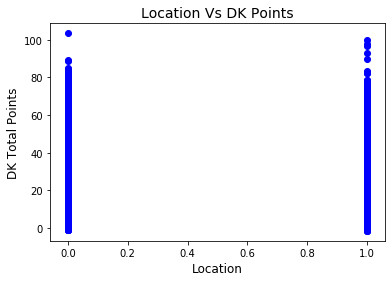

maybe better with location


In [92]:
# location	This is home or away
plt.scatter(df['location'], df['dkp'], color='blue')
plt.title('Location Vs DK Points', fontsize=14)
plt.xlabel('Location', fontsize=12)
plt.ylabel('DK Total Points', fontsize=12)
plt.show()

print('maybe better with location')

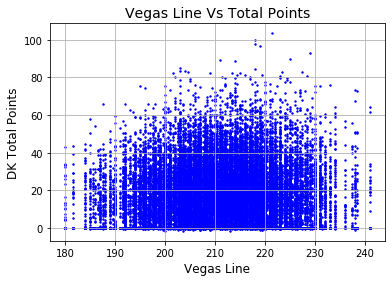

In [93]:
# spread	The spread of the game, per Vegas Line
plt.scatter(df['total'], df['dkp'], color='blue', s=2)
plt.title('Vegas Line Vs Total Points', fontsize=14)
plt.xlabel('Vegas Line', fontsize=12)
plt.ylabel('DK Total Points', fontsize=12)
plt.grid(True)
plt.show()

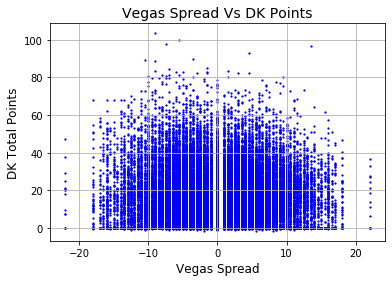

Negative exponential shape. Intuitive: the less competitive the game, individual player performance will moderate.


In [94]:
# spread	The spread of the game, per Vegas Line
plt.scatter(df['spread'], df['dkp'], color='blue',s=1.5)
plt.title('Vegas Spread Vs DK Points', fontsize=14)
plt.xlabel('Vegas Spread', fontsize=12)
plt.ylabel('DK Total Points', fontsize=12)
plt.grid(True)
plt.show()

print('Negative exponential shape. Intuitive: the less competitive the game, individual player performance will moderate.')

In [95]:
# Look at spread vs starters & salary


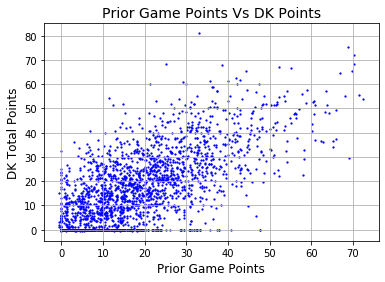

In [96]:
# prior_dkp
df_plot = df.sample(n=2500)
plt.scatter(df_plot['prior_dkp'], df_plot['dkp'], color='blue',s=1.5)
plt.title('Prior Game Points Vs DK Points', fontsize=14)
plt.xlabel('Prior Game Points', fontsize=12)
plt.ylabel('DK Total Points', fontsize=12)
plt.grid(True)
plt.show()

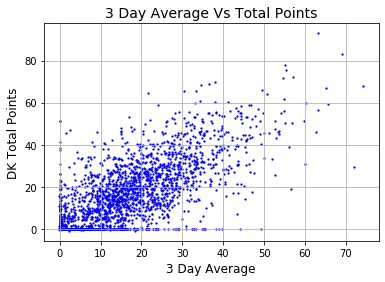

In [97]:
# three_day_avg
df_plot = df.sample(n=2500)
plt.scatter(df_plot['three_day_avg'], df_plot['dkp'], color='blue',s=1.5)
plt.title('3 Day Average Vs Total Points', fontsize=14)
plt.xlabel('3 Day Average', fontsize=12)
plt.ylabel('DK Total Points', fontsize=12)
plt.grid(True)
plt.show()

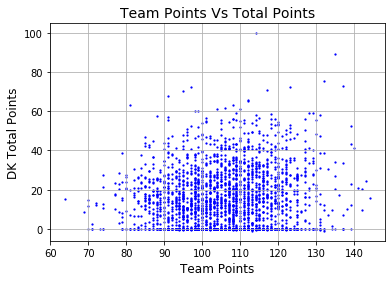

Looks like noise. Maybe some negative exp relationship


In [98]:
# team_points
df_plot = df.sample(n=2500)
plt.scatter(df_plot['team_points'], df_plot['dkp'], color='blue',s=1.5)
plt.title('Team Points Vs Total Points', fontsize=14)
plt.xlabel('Team Points', fontsize=12)
plt.ylabel('DK Total Points', fontsize=12)
plt.grid(True)
plt.show()

print('Looks like noise. Maybe some negative exp relationship')

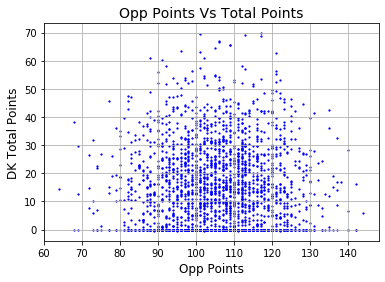

Ditto noise. Colinearities with spread and team points likely.


In [99]:
# opp_points
df_plot = df.sample(n=2500)
plt.scatter(df_plot['opp_points'], df_plot['dkp'], color='blue',s=1.5)
plt.title('Opp Points Vs Total Points', fontsize=14)
plt.xlabel('Opp Points', fontsize=12)
plt.ylabel('DK Total Points', fontsize=12)
plt.grid(True)
plt.show()

print('Ditto noise. Colinearities with spread and team points likely.')

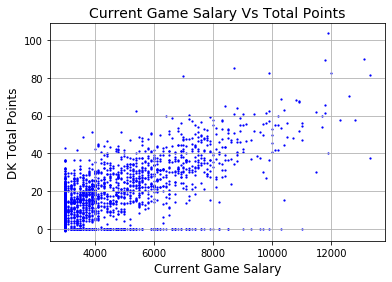

Good. Market pricing is directionally correct. 
 Note: downside risk appears greater than upside. i.e. Some obvious flops, but not much differentiation above the trend line


In [100]:
# dk_sal
df_plot = df.sample(n=2500)
plt.scatter(df_plot['dk_sal'], df_plot['dkp'], color='blue',s=1.5)
plt.title('Current Game Salary Vs Total Points', fontsize=14)
plt.xlabel('Current Game Salary', fontsize=12)
plt.ylabel('DK Total Points', fontsize=12)
plt.grid(True)
plt.show()

print('Good. Market pricing is directionally correct. \n Note: downside risk appears greater than upside. i.e. Some obvious flops, but not much differentiation above the trend line')

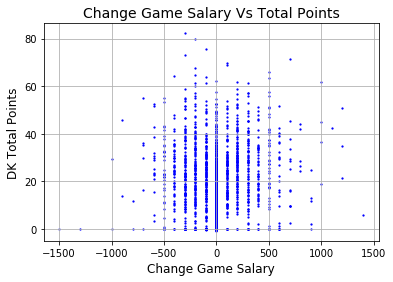

This shows consistency to me...


In [101]:
# dk_sal_change
df_plot = df.sample(n=2500)
plt.scatter(df_plot['dk_sal_change'], df_plot['dkp'], color='blue',s=1.5)
plt.title('Change Game Salary Vs Total Points', fontsize=14)
plt.xlabel('Change Game Salary', fontsize=12)
plt.ylabel('DK Total Points', fontsize=12)
plt.grid(True)
plt.show()

print('This shows consistency to me...')

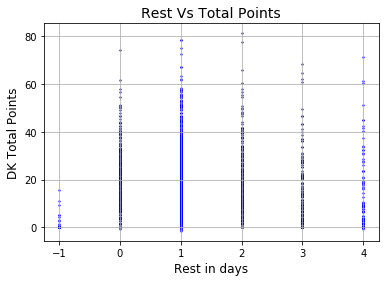

Curve seems logical: Some rest is good, too much is bad.


In [102]:
# rest_day_bucket
df_plot = df.sample(n=2500)
plt.scatter(df_plot['rest_day_bucket'], df_plot['dkp'], color='blue',s=1.5)
plt.title('Rest Vs Total Points', fontsize=14)
plt.xlabel('Rest in days', fontsize=12)
plt.ylabel('DK Total Points', fontsize=12)
plt.grid(True)
plt.show()

print('Curve seems logical: Some rest is good, too much is bad.')

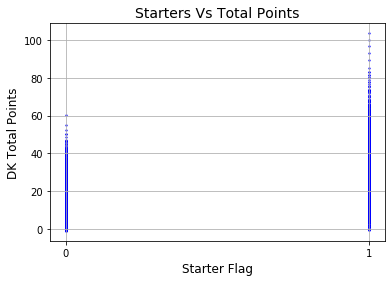

Starters score more, no obvious outliers with non-starters.


In [103]:
# start_flag
df_plot = df.sample(n=10000)
plt.scatter(df_plot['start_flag'], df_plot['dkp'], color='blue',s=1.5)
plt.title('Starters Vs Total Points', fontsize=14)
plt.xlabel('Starter Flag', fontsize=12)
plt.ylabel('DK Total Points', fontsize=12)
plt.grid(True)
plt.show()

print('Starters score more, no obvious outliers with non-starters.')

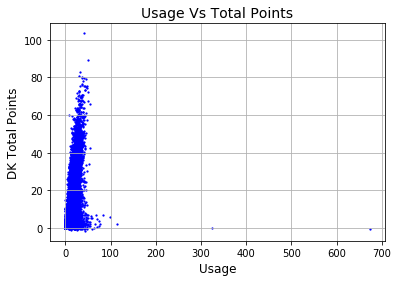

Starters score more, no obvious outliers with non-starters.


In [104]:
# usage
df_plot = df.sample(n=10000)
plt.scatter(df_plot['usage'], df_plot['dkp'], color='blue',s=1.5)
plt.title('Usage Vs Total Points', fontsize=14)
plt.xlabel('Usage', fontsize=12)
plt.ylabel('DK Total Points', fontsize=12)
plt.grid(True)
plt.show()

print('Starters score more, no obvious outliers with non-starters.')

### Naive forecast using only variables known prior to start of game

In [158]:
#from sklearn import linear_model, model_selection
import sklearn

In [159]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn import preprocessing, svm, metrics
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression 

In [116]:
df = df_16
df.dropna(inplace = True) 

In [197]:
# Fit a full model with everything
iv = ['pos',
      'actv_flag',
      'start_flag',
      'location',
      'total',
      'spread', #vegas
      'prior_dkp',
      'dkp_diff',
      'three_day_avg',
      'three_day_avg_diff', #Draft king
      'dk_sal',
      'dk_sal_change',
      'rest_day_bucket',
      'prior_game_usage',
      'prior_game_score']

# training and test sets
x = np.array(df[iv])
y = np.array(df['dkp'])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3) 

In [198]:
lm = LinearRegression().fit(x_train, y_train) 
y_pred=lm.predict(x_test)
rsq = lm.score(x_test, y_test)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('r-squared: '+str(round(rsq,5))
     +'\nMSE: '+str(round(mse,5))
     +'\nRMSE: '+str(round(rmse,5))) 
lm_res = pd.DataFrame.from_dict(dict(zip(iv, lm.coef_)), orient='index',columns=['coef'])
lm_res
#lm.intercept_

r-squared: 0.6686
MSE: 75.61862
RMSE: 8.6959


,coef
pos,0.017528
actv_flag,3.964014
start_flag,6.976841
location,-0.180763
total,0.030856
spread,-0.010037
prior_dkp,0.058809
dkp_diff,-0.034629
three_day_avg,0.269829
three_day_avg_diff,-0.036616


In [ ]:
# Variables to lag
    '''
         ,'min_played'
         , 'fgm', 'fga', 'pt','rb', 'as', 'st', 'bl', 'to', 'three_point_attempts',
       'three_point_made', 'ftm', 'fta', 'off_reb', 'def_reb', 'fouls',
       'teamfga', 'teamfta', 'teamto', 'teamOR', 'teamDR', 'teamFGM', 'oppfga',
       'oppfta', 'oppto', 'oppOR', 'oppDR', 'oppFGM', 'usage',
       , 'possessions',
       'ppp', 'oppdfeff'
        '''

#### Notes from Jason

*Two main types of games: Tournaments vs cash games*
    
    -cash games head to head
    -Tournaments -- need blow out to win

*Strategies often focus on big names yielding consistent points or finding value on the bench to capitalize on injuries*
    
    Depending on the DK format, (eg tournament vs head-to-head) hidden value needs to also be uncorrelated with other lineups
    

*To find hidden value, focus needs to be on player efficiency and then forecast utilization*
    
    Start by assuming all playing time is equal (ie no garbage time)
        Plot of DKP vs vegas spread suggests there is garbage time --> address later
    Fouls aren't in dataset, but might need to be    
 